# NPFE classification and processing

This notebook supports the detection and description of new particle formation events (NPFEs) that may have occurred on specific days and places. 

The notebook also supports the processing of NPFE descriptions.

Start by setting up the notebook. First, you need to provide your gcube token and load the provided functions. Then you can start analysing days (YYYY-MM-DD) and places (Hyytiaelae).

## Setup

In [23]:
import os

# In the Terminal, export GCUBE_TOKEN=''
gcube_token = os.environ['GCUBE_TOKEN']
# Alternatively, include the token here
# gcube_token = ''

In [105]:
import logging
import requests
import pandas as pd
from io import BytesIO, StringIO
from lxml import etree as et
from IPython.display import Image, display
from owslib.wps import WebProcessingService, ComplexDataInput, monitorExecution

logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)
dataminer_url = 'http://dataminer-prototypes.d4science.org/wps/WebProcessingService'
headers = {'gcube-token': gcube_token}
wps = WebProcessingService(dataminer_url, headers=headers)

def visualize(day, place):
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFFETCHPLOTDATA'
    execution = wps.execute(identifier, [('day', day),('place', place)], output="non_deterministic_output")
    monitorExecution(execution, sleepSecs=5, download=False)
    output = execution.processOutputs[0]
    doc = et.parse(BytesIO(output.retrieveData(headers=headers)))
    plotUrl = doc.xpath('/ogr:FeatureCollection/gml:featureMember/ogr:Result/d4science:Description[text() = "plot"]/../d4science:Data/text()', namespaces={
        'ogr': 'http://ogr.maptools.org/',
        'gml': 'http://www.opengis.net/gml',
        'd4science': 'http://www.d4science.org'
    })[0]
    display(Image(url=plotUrl, format='png', embed=True))
        
def record(day, place, beginning, end, classification):
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFSTOREDATA'
    execution = wps.execute(identifier, [('day', day),('place', place),('beginning', beginning),('end', end),('classification', classification)], output="non_deterministic_output")
    
def read():
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFREADDATA'
    execution = wps.execute(identifier, inputs=[('place', place)], output="non_deterministic_output")
    monitorExecution(execution, sleepSecs=2, download=False)
    output = execution.processOutputs[0]
    doc = et.parse(BytesIO(output.retrieveData(headers=headers)))
    outputUrl = doc.xpath('/ogr:FeatureCollection/gml:featureMember/ogr:Result/d4science:Description[text() = "output"]/../d4science:Data/text()', namespaces={
        'ogr': 'http://ogr.maptools.org/',
        'gml': 'http://www.opengis.net/gml',
        'd4science': 'http://www.d4science.org'})[0]
    return pd.read_csv(StringIO(requests.get(outputUrl).content.decode('utf-8')))

## Classification

In this section you can detect and describe NPFEs. We use primary data, specifically particle size distribution observational data, visualize primary data to detect and describe NPFEs. A specific task here is to classify events. Recording event descriptions automatically catalogues corresponding data files, as RDF data in Turtle syntax.

In [100]:
# Event days (Class Ia)
# 2007-04-15, 2007-05-05, 2007-05-18, 2007-10-19, 2008-02-19, 2009-03-19, 2009-03-22 
# 2011-03-15, 2011-04-19, 2011-10-01, 2012-05-01, 2012-05-29, 2013-02-20, 2013-04-04
#
# Non Event days
# 2007-04-20, 2008-02-20, 2009-04-03, 2011-04-21, 2012-05-05, 2013-02-21

day = '2009-03-22'
place = 'Hyytiaelae'

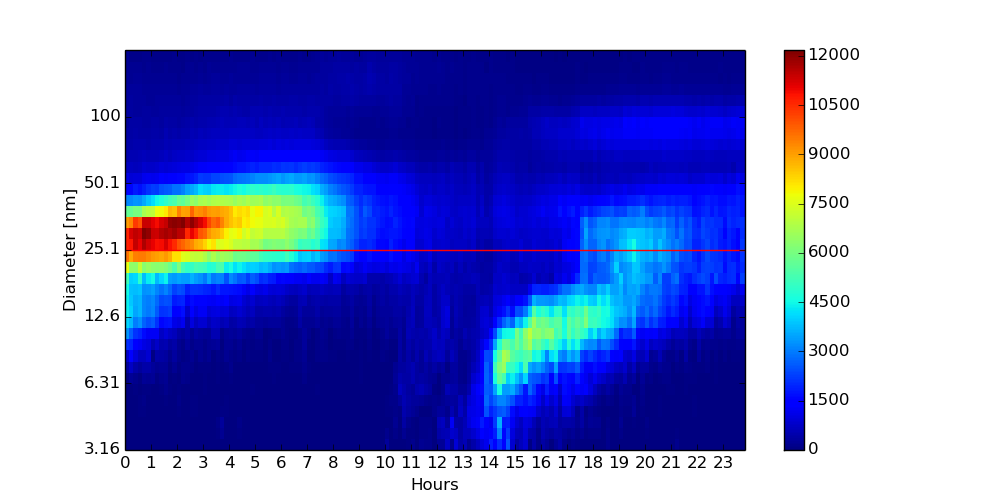

In [101]:
visualize(day, place)

In [102]:
record(day, place, '13:30', '15:00', 'Class Ia')

## Processing

The catalogued event descriptions can be read into a data frame, which is subsequently used to process event descriptions e.g., to compute average event durations or plot events on maps. Note that the system automatically translates the catalogued data into a data frame, which is easier to manipulate for data analysis.

In [109]:
# Note that this takes a couple of seconds; wait before you continue ...
df = read()

In [110]:
df

,beginning,end,classification,place,latitude,longitude
0,2007-04-15T11:00:00+03:00,2007-04-15T12:00:00+03:00,Class Ia,Hyytiälä,61.84562,24.29077
1,2009-03-22T13:30:00+02:00,2009-03-22T15:00:00+02:00,Class Ia,Hyytiälä,61.84562,24.29077
2,2013-02-20T12:30:00+02:00,2013-02-20T15:00:00+02:00,Class Ia,Hyytiälä,61.84562,24.29077
3,2013-04-04T10:30:00+03:00,2013-04-04T12:00:00+03:00,Class Ia,Hyytiälä,61.84562,24.29077
4,2017-01-01T12:00:00+02:00,2017-01-01T15:00:00+02:00,Class Ia,Hyytiälä,61.84562,24.29077
